# Pedestrian Detection using YOLOv8

## Introduction
In this notebook, we implement a YOLOv8 model to detect pedestrians in images. This includes downloading a custom dataset, preprocessing the data, training the model, and evaluating its performance. Finally, we will use the trained model to make predictions on new images.

---

## Environment Setup

### Check GPU Status and Install Required Libraries
```python
!nvidia-smi

!pip install roboflow
!pip install ultralytics


* !nvidia-smi: Checks if NVIDIA GPU is available and its status.
* !pip install roboflow: Installs the Roboflow library for dataset management.
* !pip install ultralytics: Installs the Ultralytics library for YOLOv8 implementation.

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install roboflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 538.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.1/872.1 kB 5.7 MB/s eta 0:00:00


# Dataset Downloading

Download Pedestrian Dataset from Roboflow

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="8O2SnzKvuxgjcUwLWMgt")
project = rf.workspace("ptcriuer").project("pedestrian-data-500")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.87, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to pedestrian-data-500-1 in yolov8:: 100%|██████████| 1012/1012 [00:00<00:00, 6219.57it/s]


This code connects to the Roboflow platform and downloads the "Pedestrian Data" dataset using the provided API key.

# Importing Libraries and Verifying Installation

Import Required Libraries and Verify YOLOv8 Installation

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython.display import display, Image
from IPython import display
display.clear_output()
! yolo mode= checks

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 771, in entrypoint
    raise ValueError(f"Invalid 'mode={mode}'. Valid modes are {MODES}.\n{CLI_HELP_MSG}")
ValueError: Invalid 'mode=<module 'ultralytics.utils.checks' from '/usr/local/lib/python3.10/dist-packages/ultralytics/utils/checks.py'>'. Valid modes are {'train', 'predict', 'export', 'benchmark', 'track', 'val'}.

    Arguments received: ['yolo', 'mode=', 'checks']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of {'classify', 'segment', 'obb', 'pose', 'detect'}
                MODE (required) is one of {'train', 'predict', 'export', 'benchmark', 'track', 'val'}
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS a

* os, cv2, matplotlib: Essential libraries for file operations, image processing, and plotting.
* ultralytics.YOLO: Library to work with the YOLOv8 model.
* display.clear_output(): Clears previous outputs to keep the notebook clean.
* ! yolo mode=checks: Verifies the installation of the YOLOv8 environment.

# Display Example Image

Load and Display an Example Image with Annotations

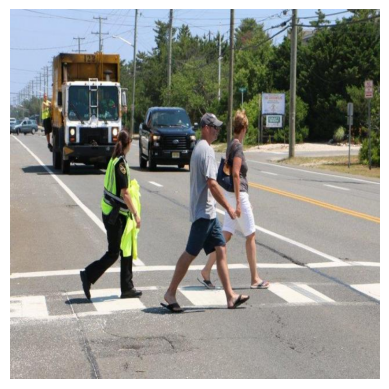

In [ ]:
# Load and display an example image
image_file = os.path.join('/content/pedestrian-data-500-1/train/images/-9bd1fb0493d1c729_JPG_jpg.rf.eafc5e6aae20de0af78e5d0057c00ce3.jpg')

# Read and display image
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Image Preprocessing

Resize All Images in the Dataset

In [ ]:
# Define the paths to the images and labels subfolders
images_path = os.path.join('/content/pedestrian-data-500-1/train/images')

output_size = (640, 640)  # YOLO input size

# Resize images in the images folder
for filename in os.listdir(images_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust for your image formats
        img_path = os.path.join(images_path, filename)
        image = cv2.imread(img_path)

        if image is not None:  # Check if the image was read successfully
            resized_image = cv2.resize(image, output_size)
            cv2.imwrite(img_path, resized_image)  # Overwrite with resized image
        else:
            print(f"Error reading image: {img_path}")

Resizes all images in the training dataset to 640x640 pixels, which is the input size required by YOLOv8.

# Display Images from Datasets

Display Sample Images from Training, Validation, and Test Sets

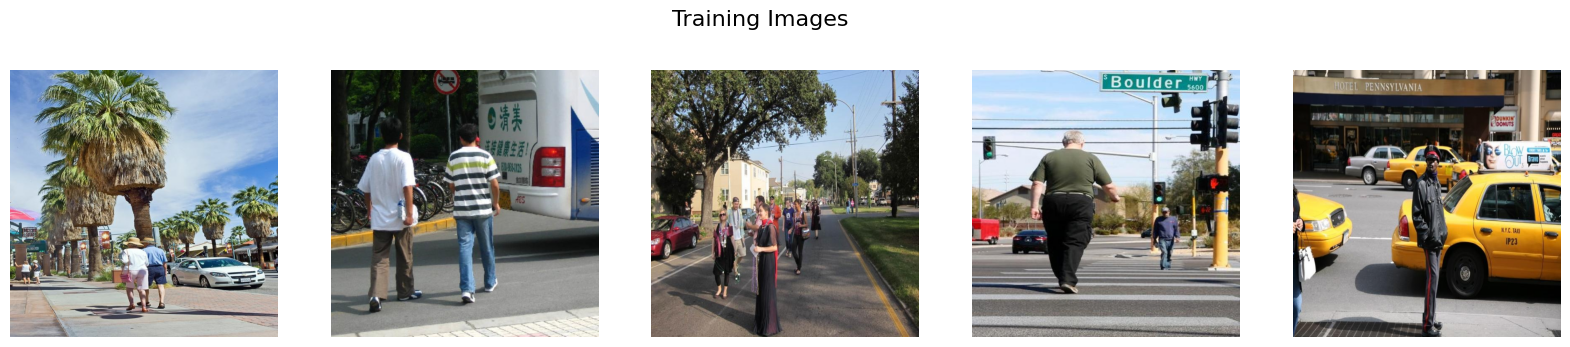

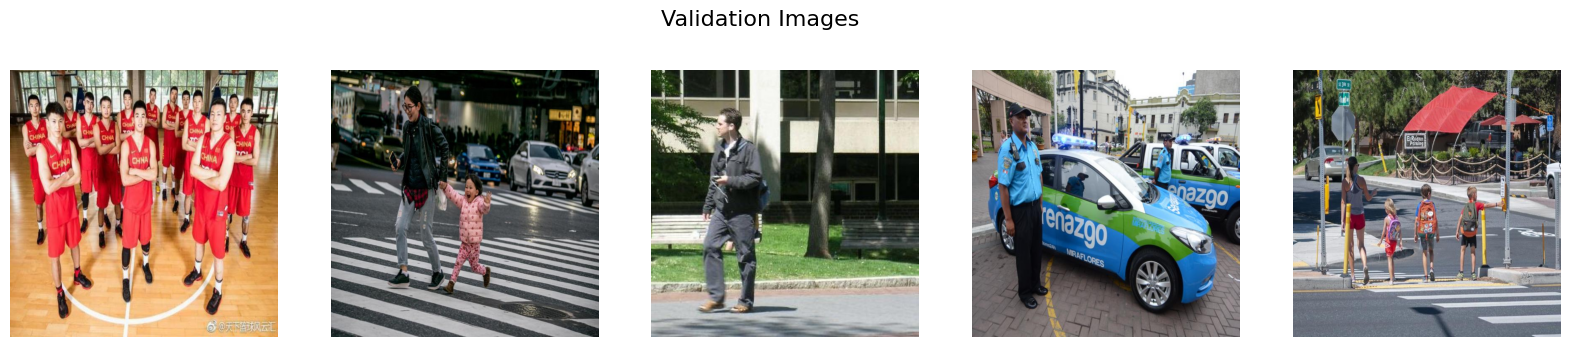

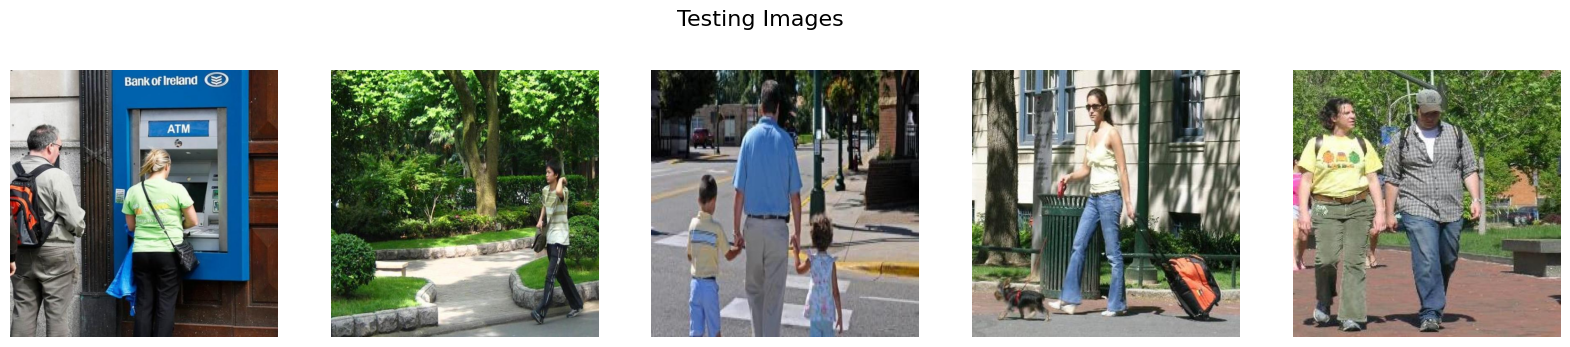

In [ ]:
train_dataset_path= '/content/pedestrian-data-500-1/train/images'
test_dataset_path='/content/pedestrian-data-500-1/test/images'
valid_dataset_path='/content/pedestrian-data-500-1/valid/images'

# Function to load and display images
def display_images(dataset_path, title):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(title, fontsize=16)

    for i, filename in enumerate(os.listdir(dataset_path)[:5]):
        image_path = os.path.join(dataset_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        axs[i].imshow(image)
        axs[i].axis('off')

    plt.show()

# Display 5 images from each dataset

display_images(train_dataset_path, "Training Images")
display_images(valid_dataset_path, "Validation Images")
display_images(test_dataset_path, "Testing Images")

Displays 5 random images from the training, validation, and test datasets to provide a visual understanding of the data.

# Training the YOLOv8 Model

Train the YOLOv8 Model with Custom Settings:
Trains the YOLOv8 model (yolov8n.pt) using the custom dataset with specified augmentation techniques (flip, mixup, shear) and training configurations (epochs, batch size, etc.).

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt data=/content/pedestrian-data-500-1/data.yaml epochs=50 flipud=0.5 mixup=0.5 imgsz=640 shear=0.1 batch=64 patience=10 seed=0

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/pedestrian-data-500-1/data.yaml, epochs=50, time=None, patience=10, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

# Evaluate the Model

Display Evaluation Metrics and Results:

Displays the confusion matrix, normalized confusion matrix, and training results to evaluate model performance.

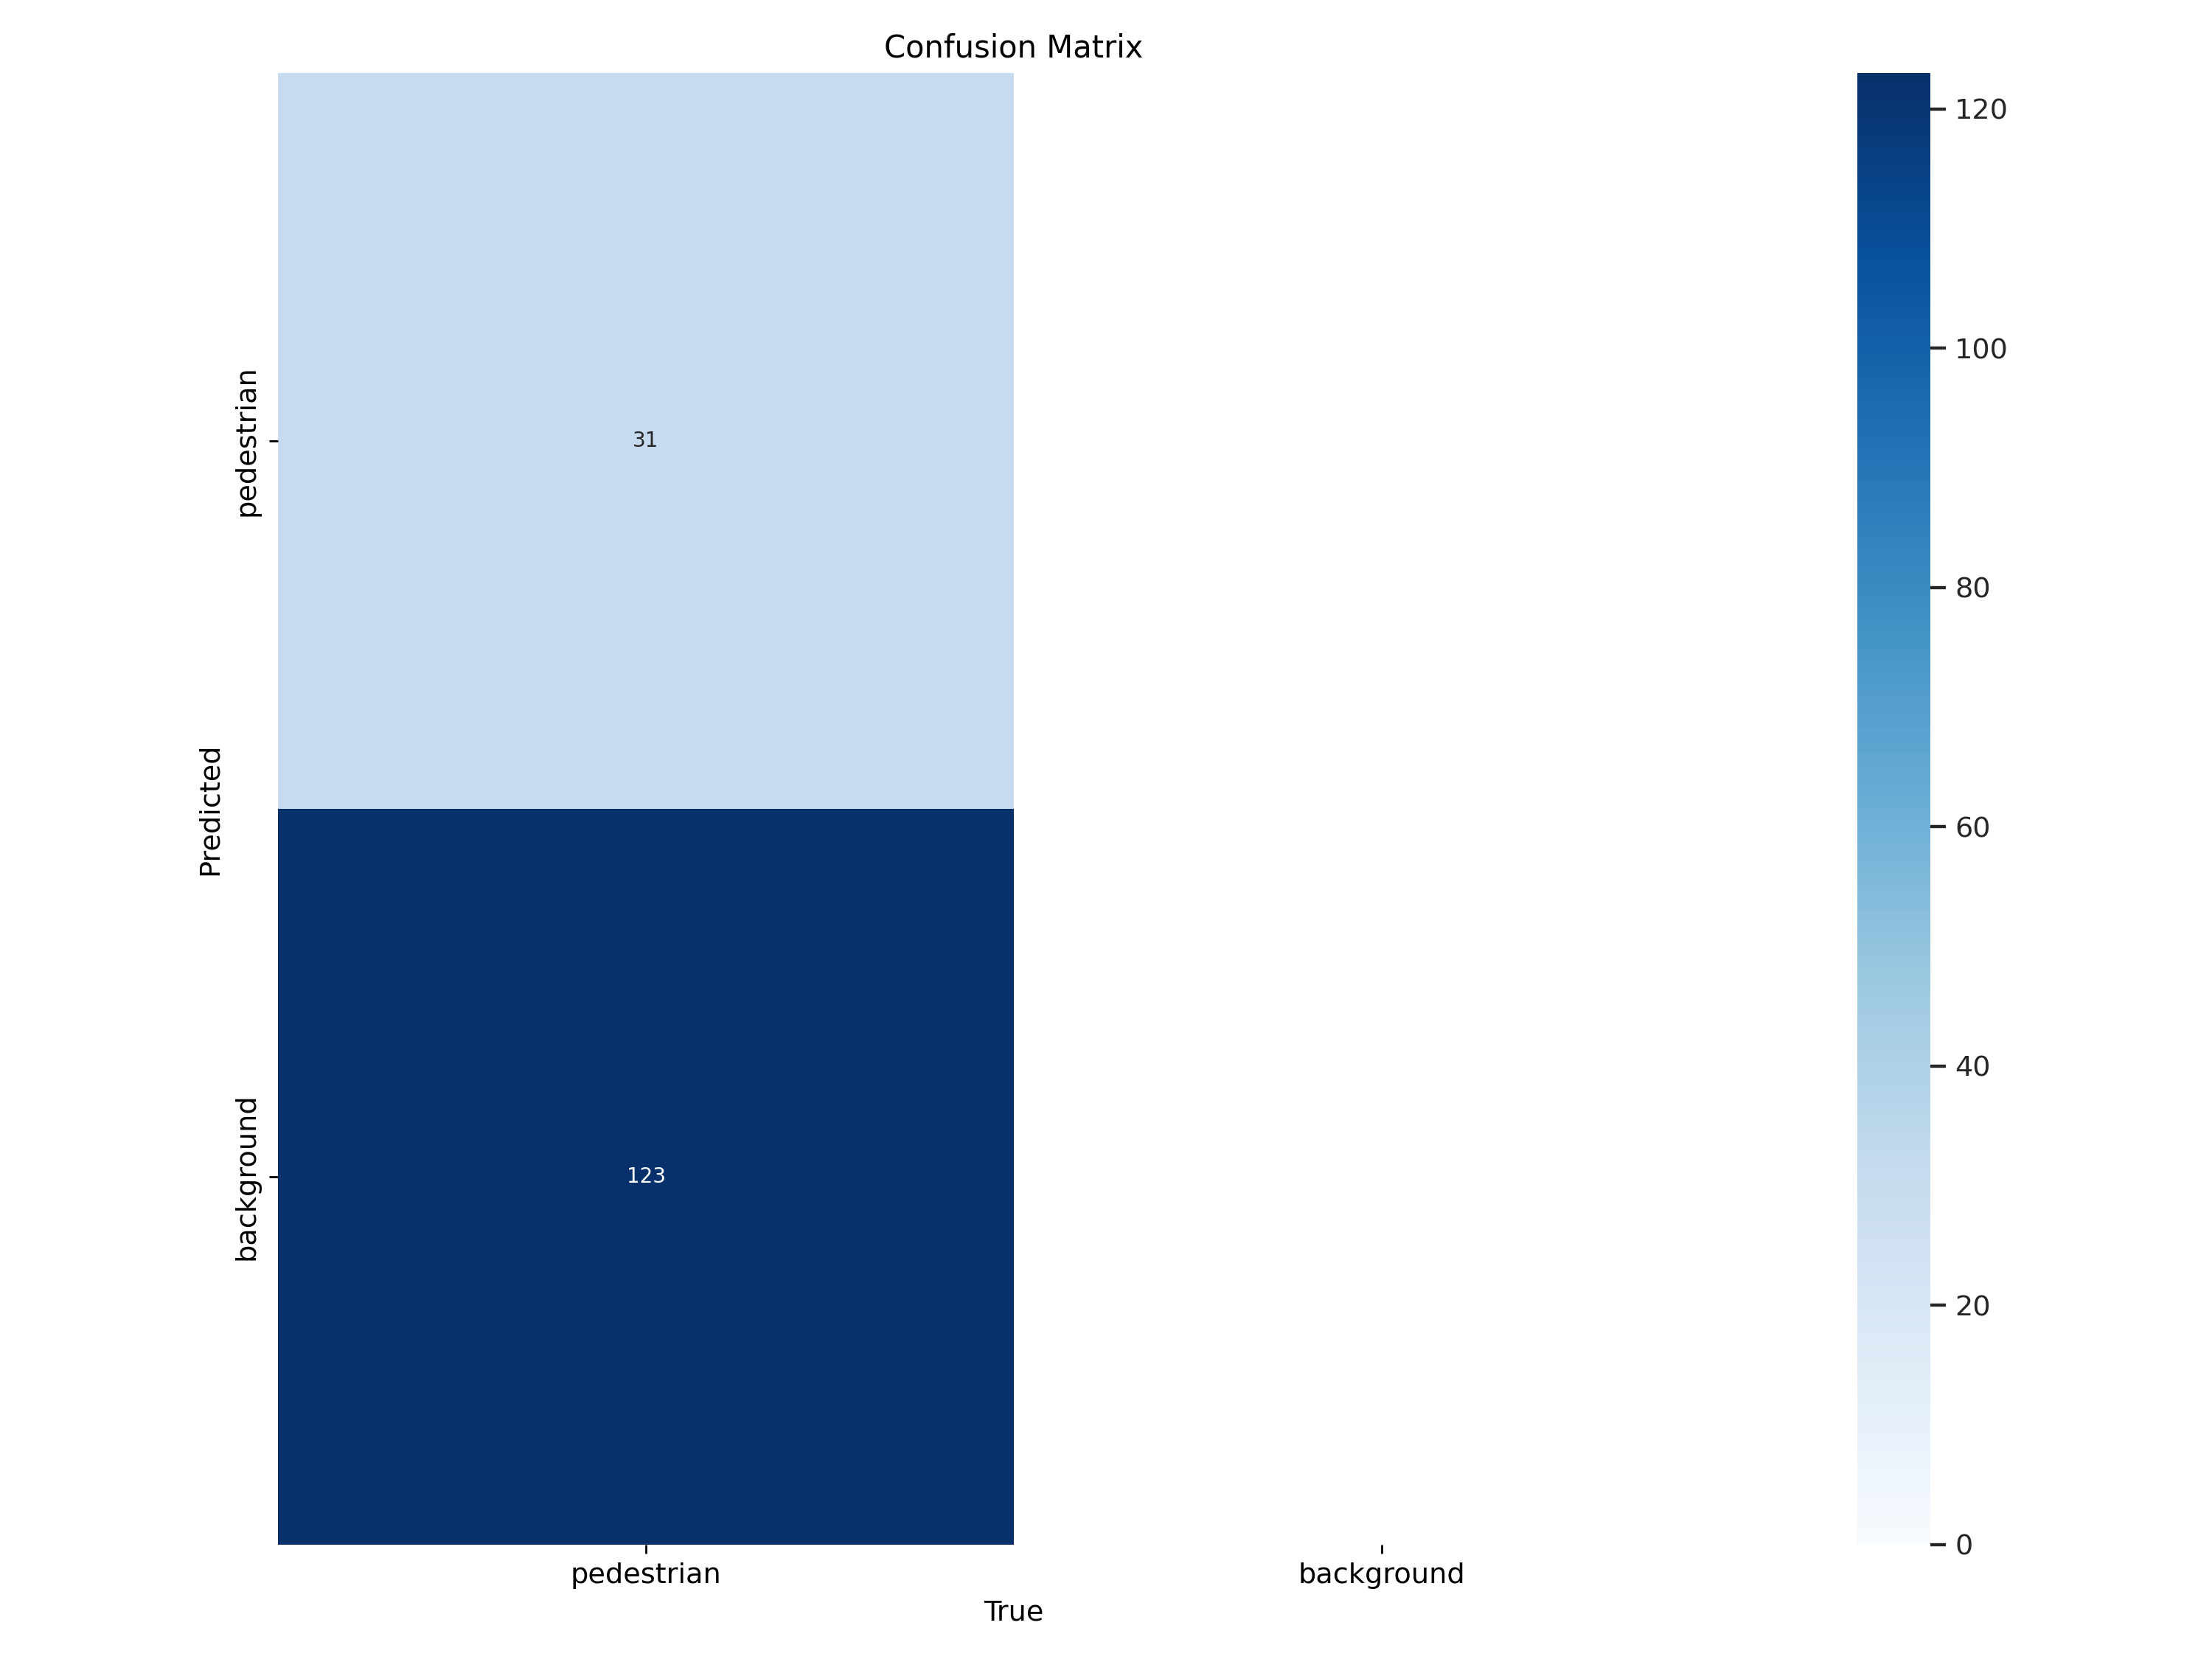

In [ ]:
Image(filename=f'/content/runs/detect/train2/confusion_matrix.png', width=600)

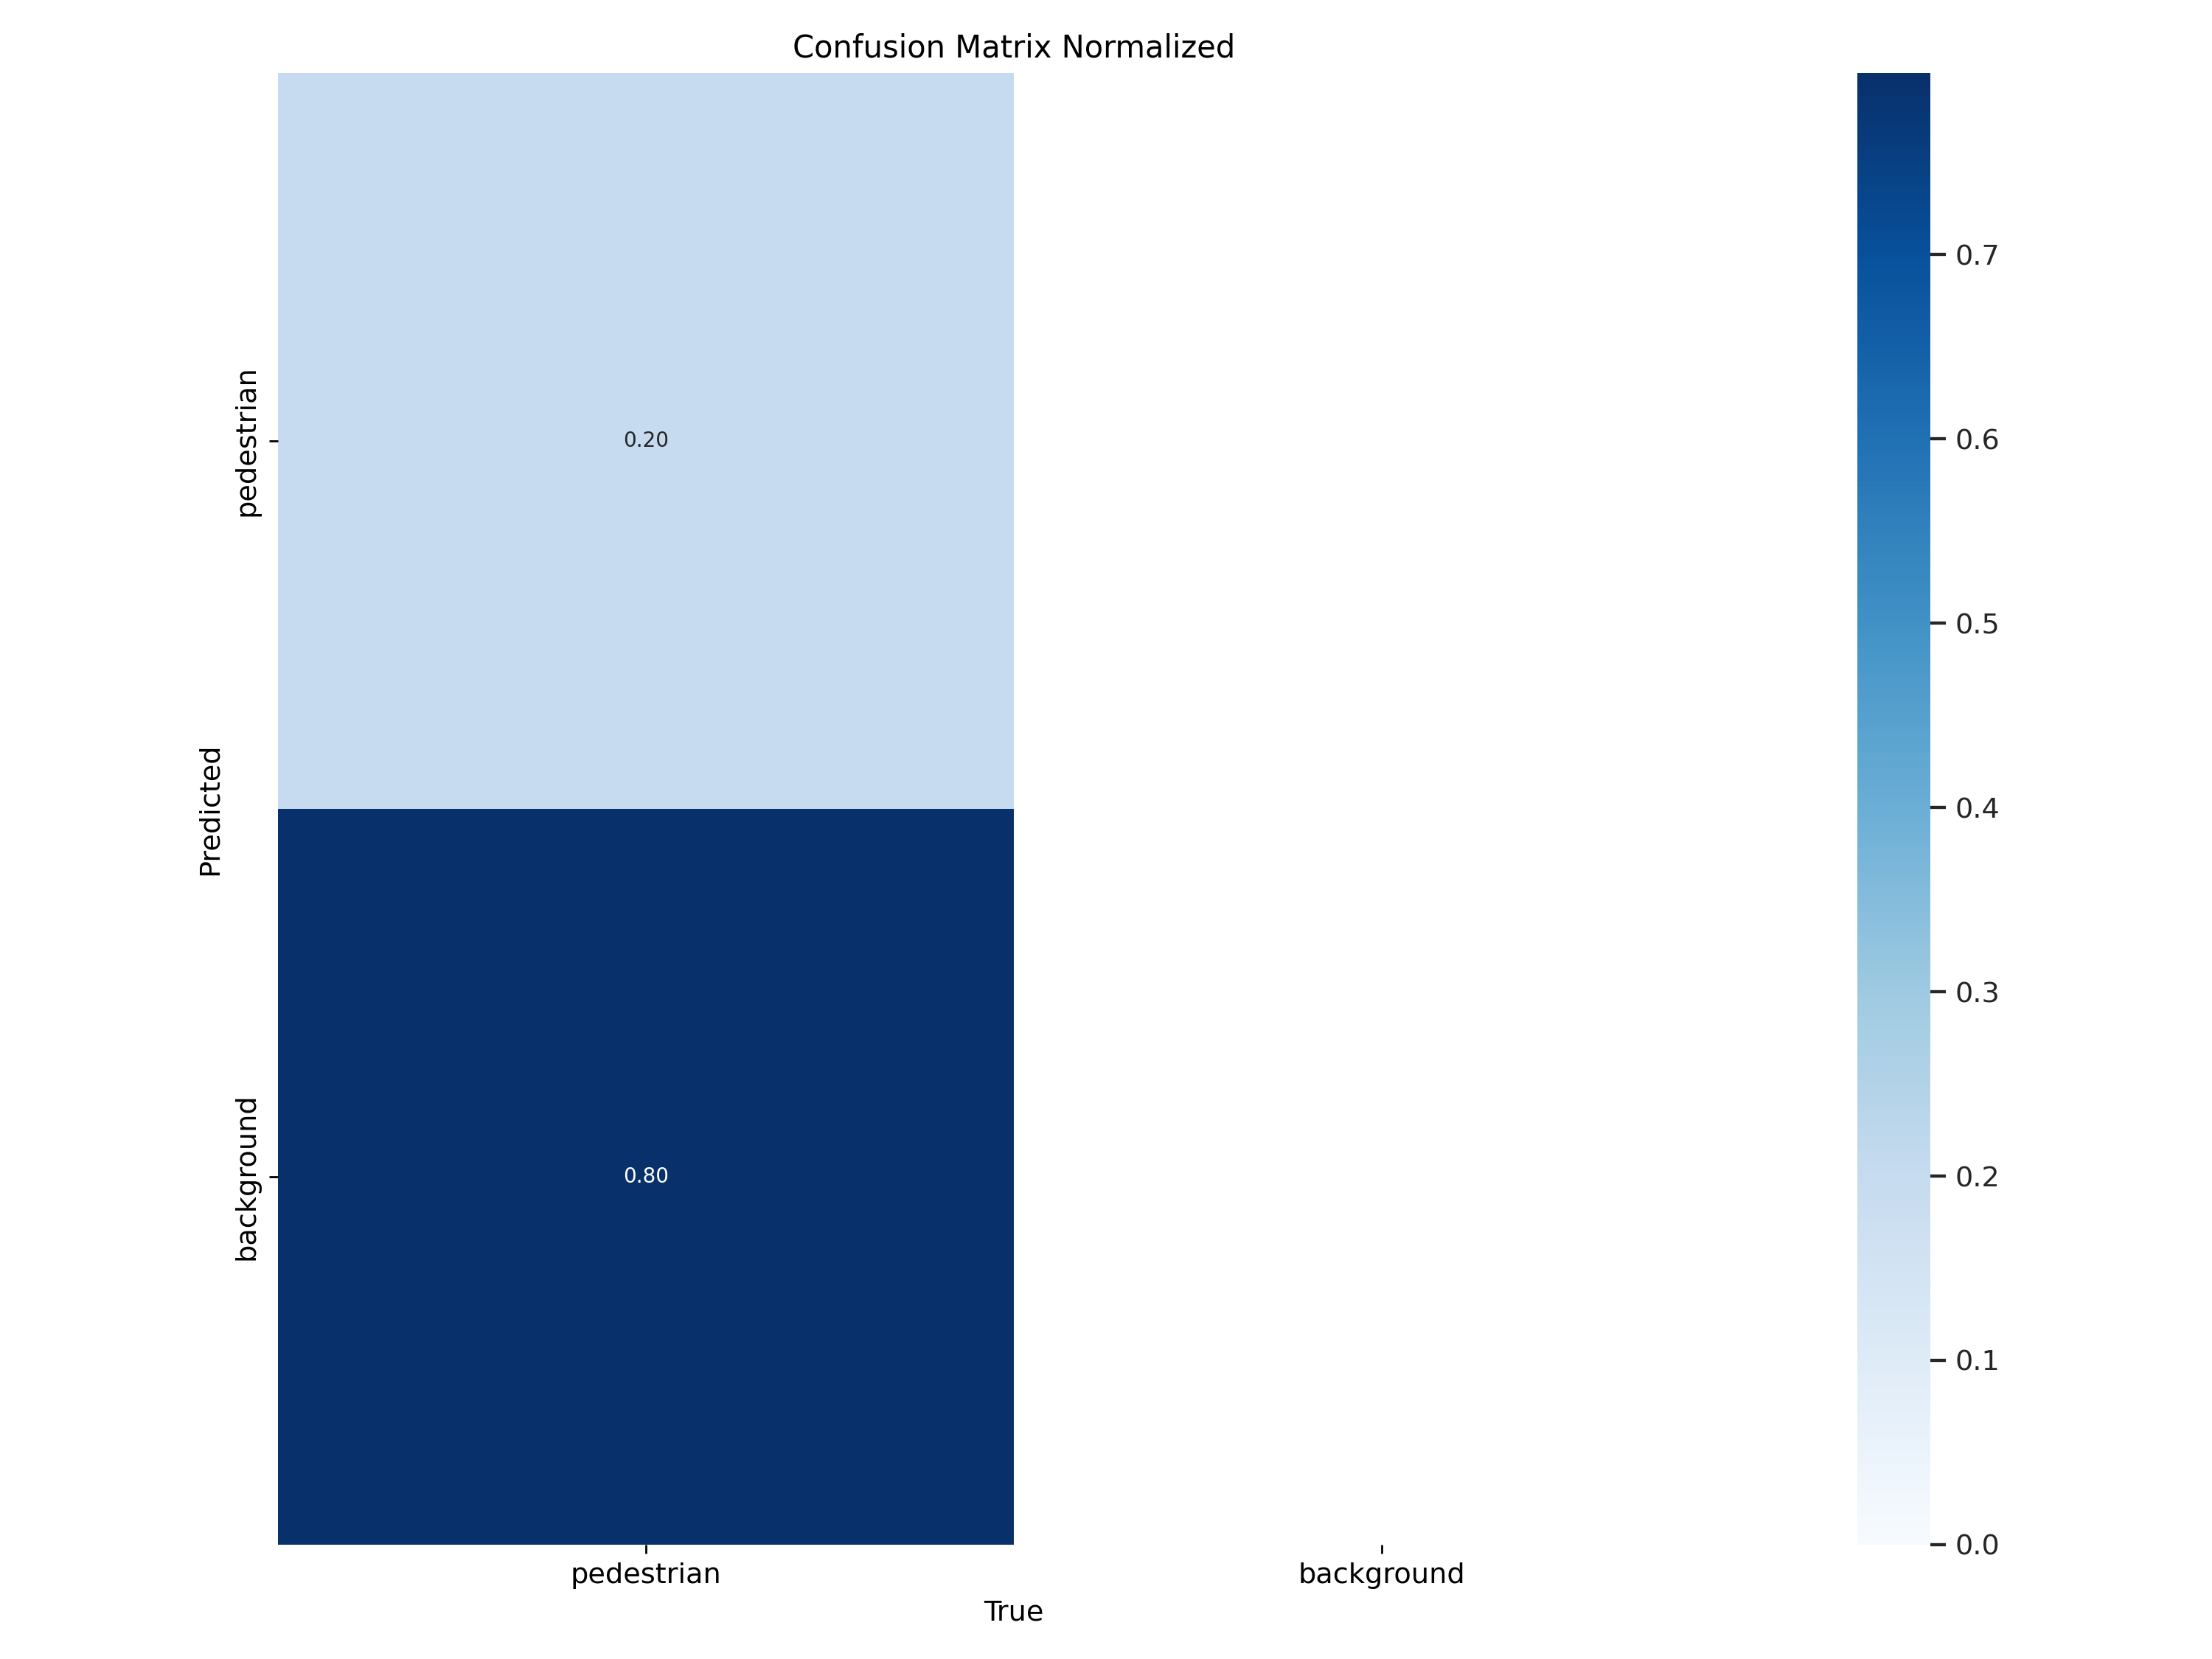

In [ ]:
Image(filename=f'/content/runs/detect/train2/confusion_matrix_normalized.png', width=600)

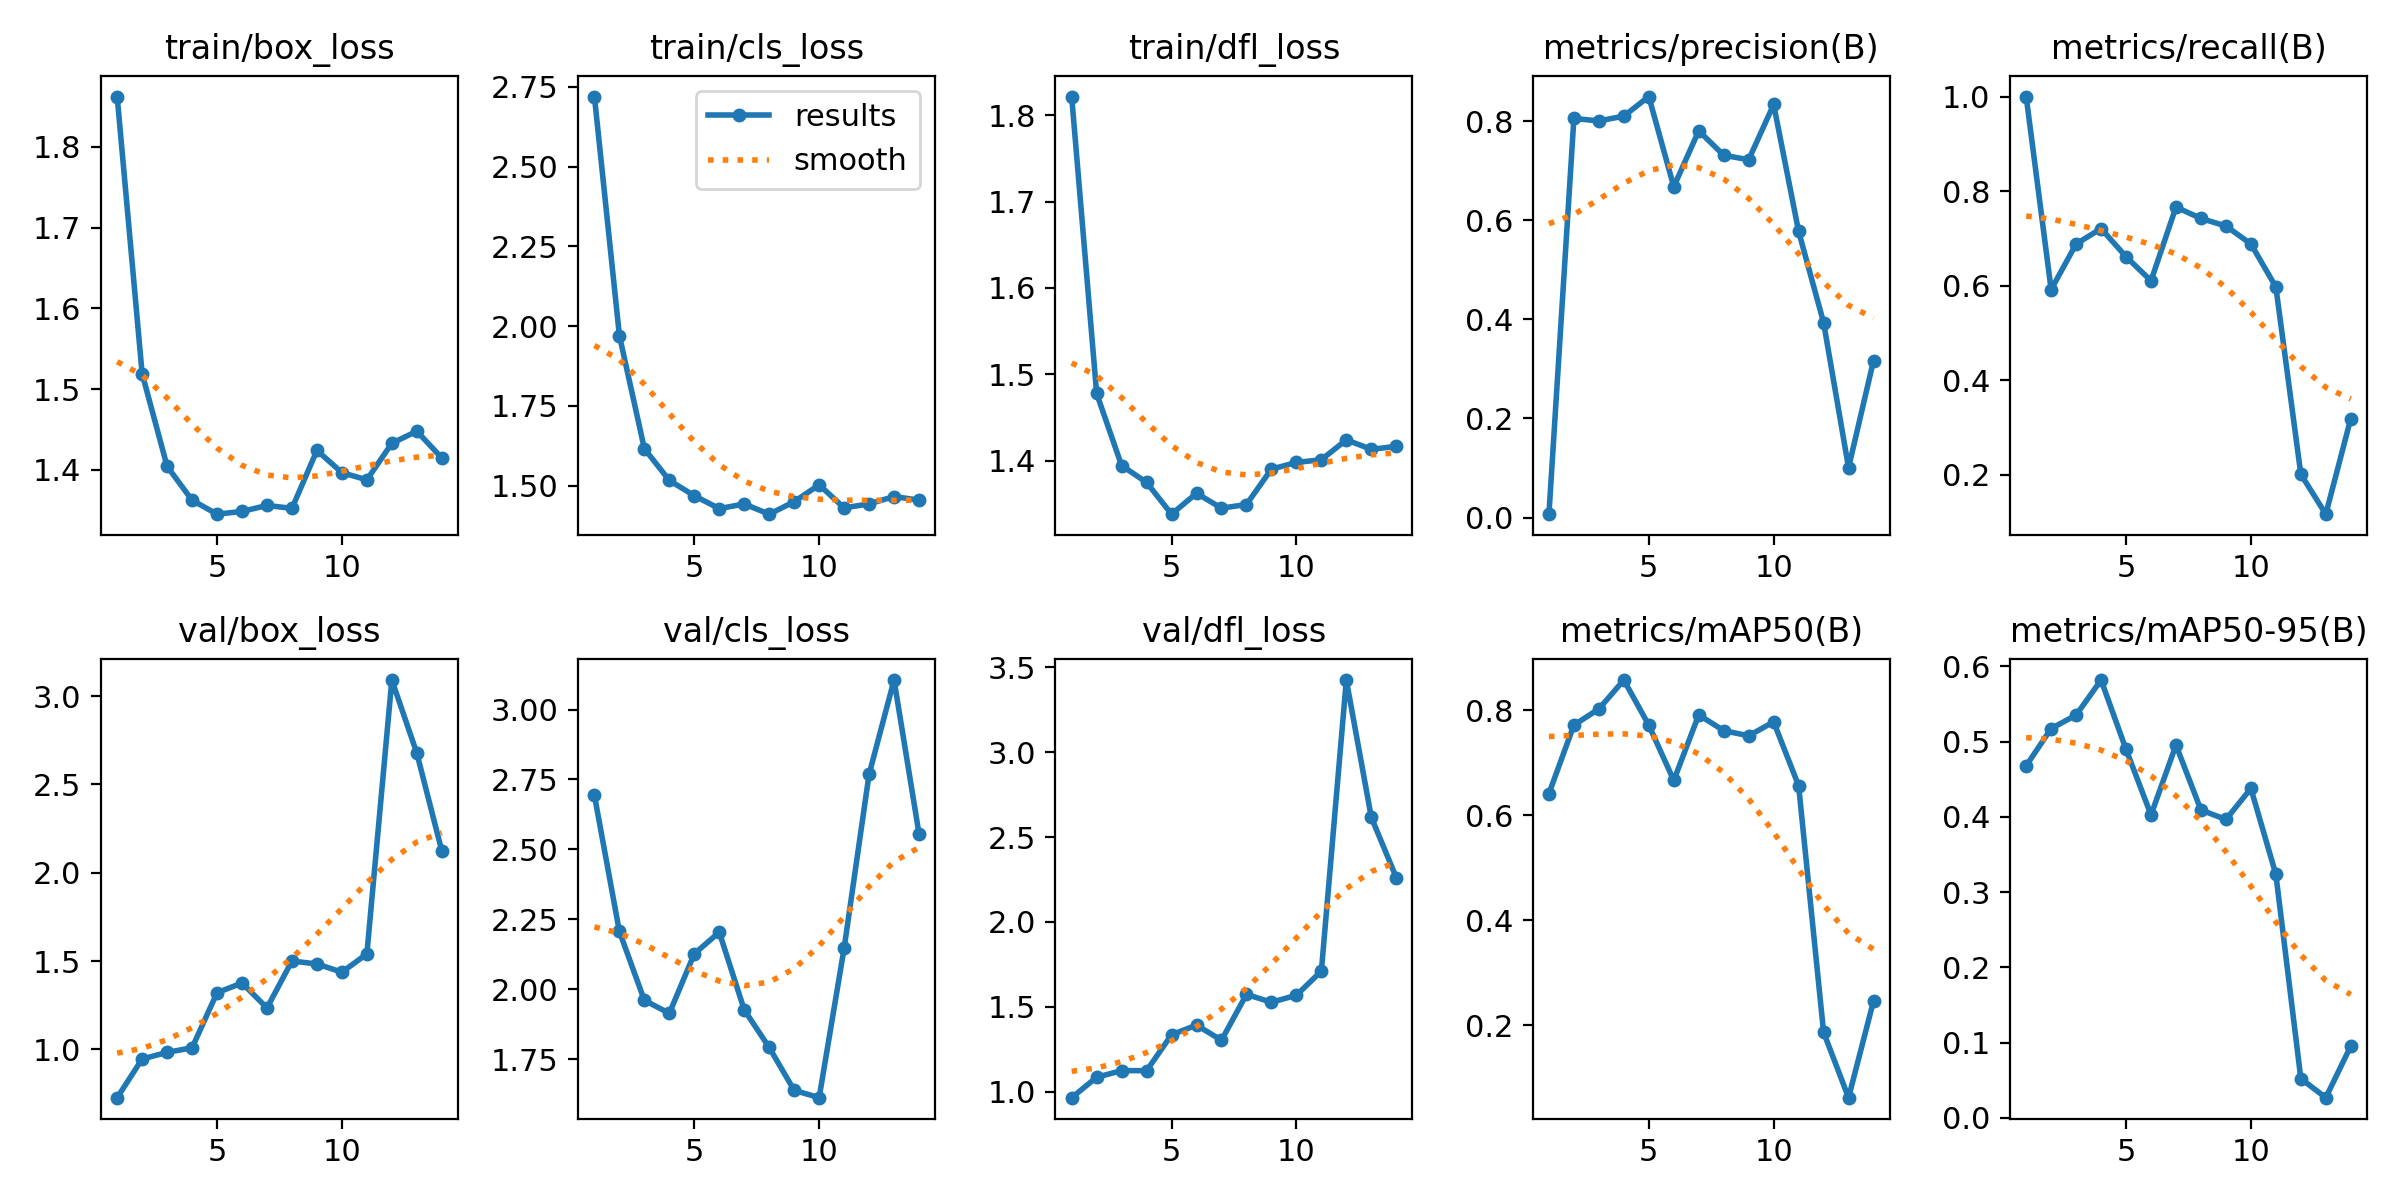

In [ ]:
Image(filename=f'/content/runs/detect/train2/results.png', width=600)

# Validate the Model

Validate the YOLOv8 Model:

Validates the best model obtained during training on the validation dataset.

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train2/weights/best.pt data=/content/pedestrian-data-500-1/data.yaml

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/pedestrian-data-500-1/valid/labels.cache... 75 images, 0 backgrounds, 0 corrupt: 100% 75/75 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:04<00:00,  1.18it/s]
                   all         75        154       0.81      0.721      0.854      0.579
Speed: 1.7ms preprocess, 44.0ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


# Predict and Display Results

Predict and Display Results on Test Images:

Uses the trained model to make predictions on the test dataset and displays the resulting images with detected objects.

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train2/weights/best.pt source=/content/pedestrian-data-500-1/test/images

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

image 1/25 /content/pedestrian-data-500-1/test/images/001296_jpg.rf.fe55833c267b7be6978abdff5094ead2.jpg: 640x640 (no detections), 70.1ms
image 2/25 /content/pedestrian-data-500-1/test/images/ATM_queue10_jpg.rf.012152f798964821f50b0c621787ce45.jpg: 640x640 (no detections), 46.9ms
image 3/25 /content/pedestrian-data-500-1/test/images/ATM_queue32_jpg.rf.1f9038915c7a8813a5e072b0fd7b62b6.jpg: 640x640 3 pedestrians, 46.2ms
image 4/25 /content/pedestrian-data-500-1/test/images/ATM_queue4_jpg.rf.411b27c7df94ba45524f1f7cf7faccd6.jpg: 640x640 (no detections), 41.3ms
image 5/25 /content/pedestrian-data-500-1/test/images/FudanPed00024_png_jpg.rf.e21a6c16499822b88618f8dd0c3d9cf7.jpg: 640x640 (no detections), 47.5ms
image 6/25 /content/pedestrian-data-500-1/test/images/FudanPed00032_png_jpg.rf.5176c1046be241063e6ded8600451133.jpg: 640x64

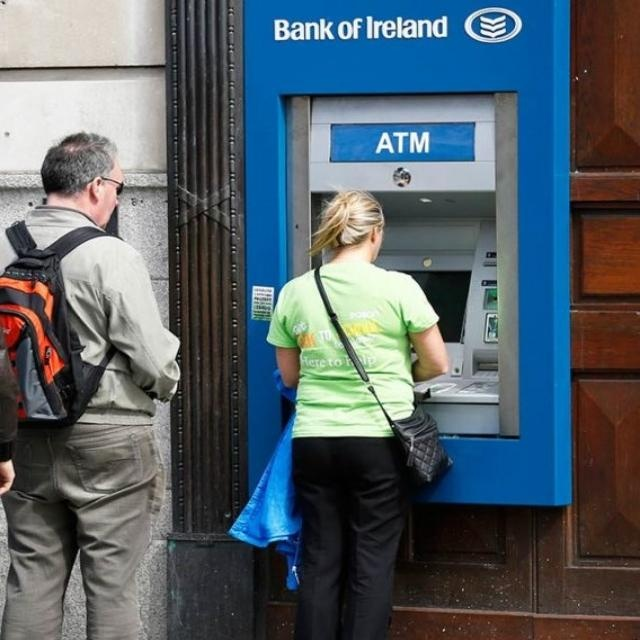

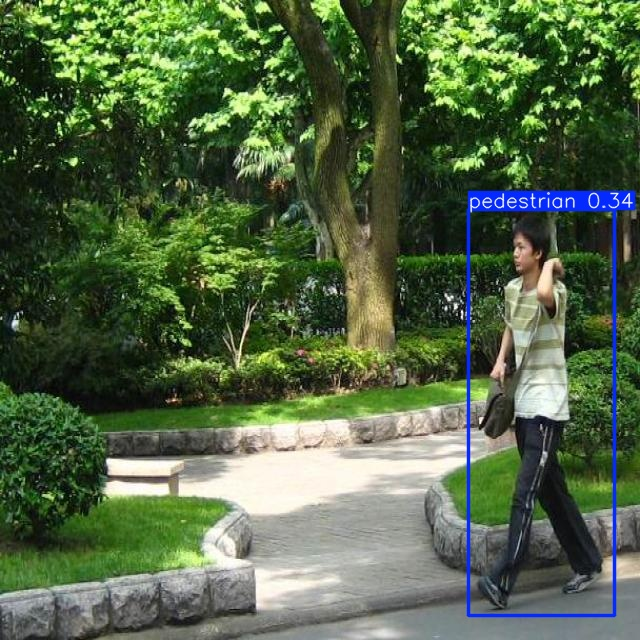

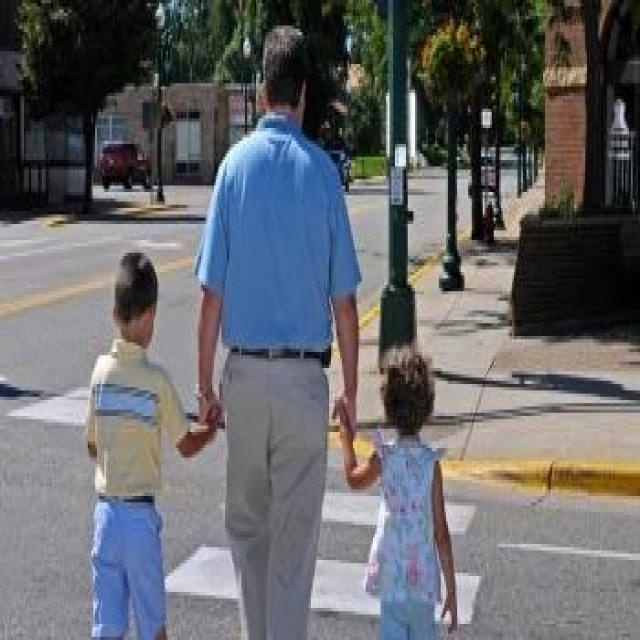

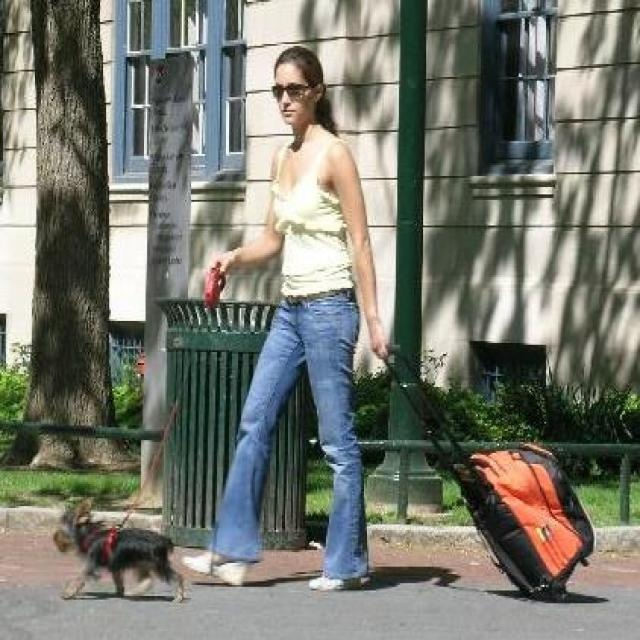

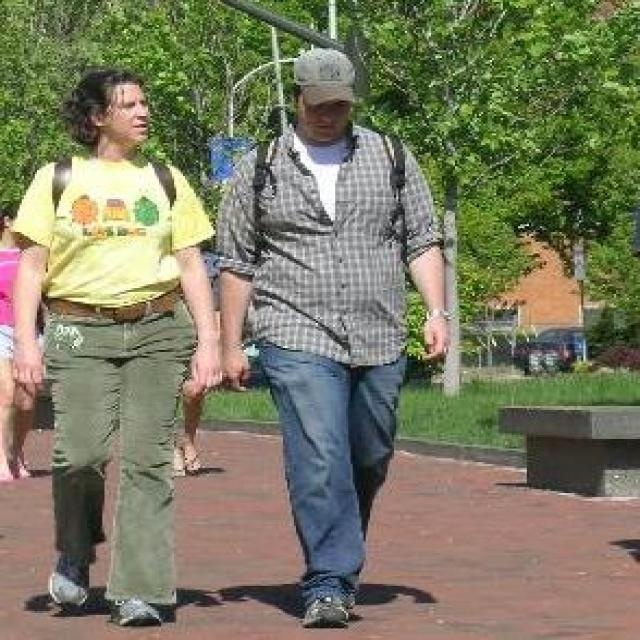

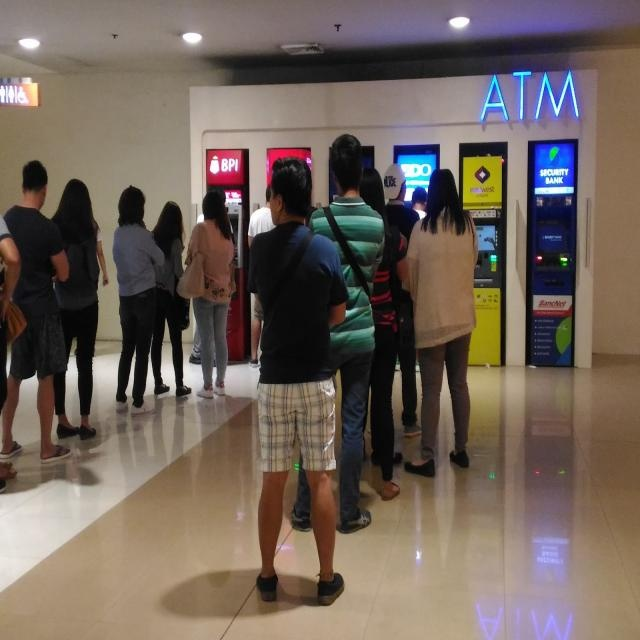

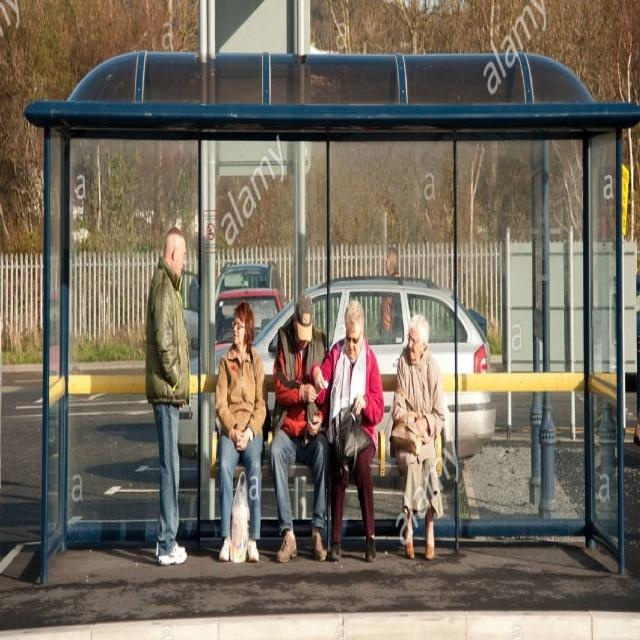

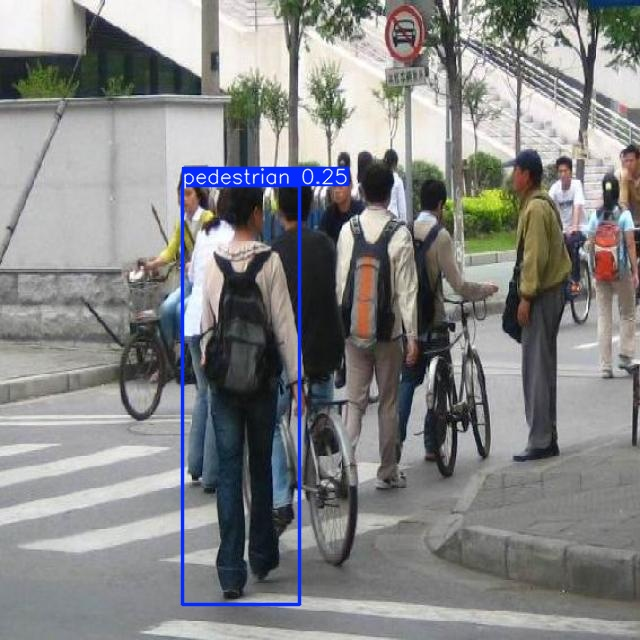

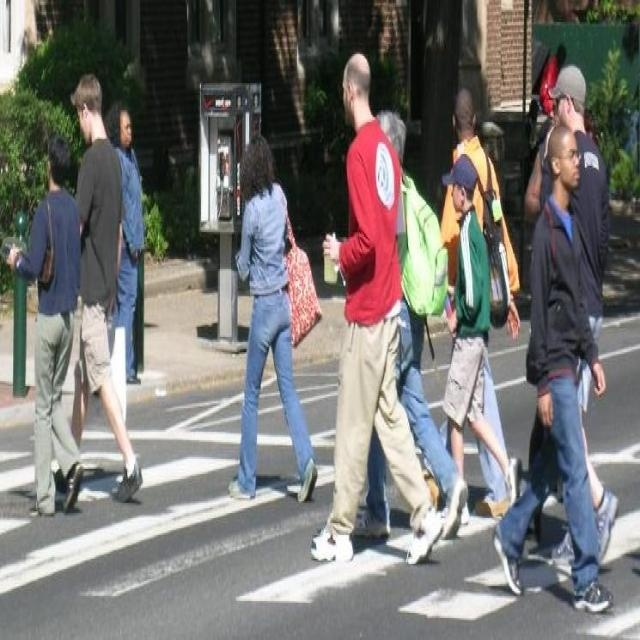

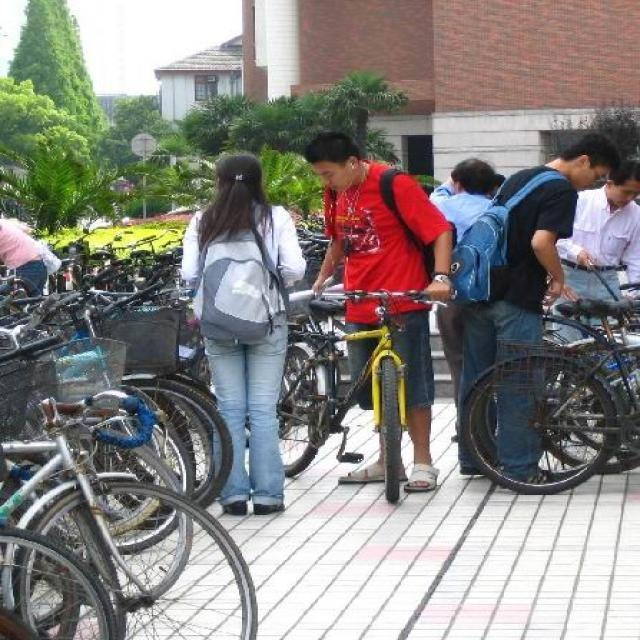

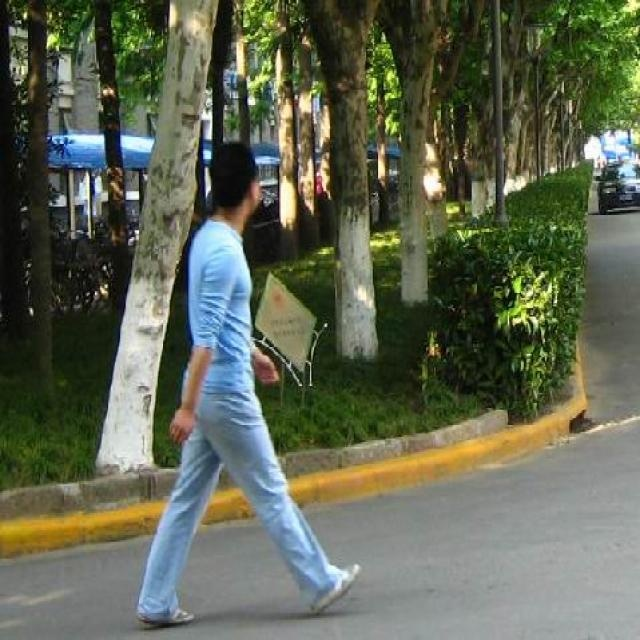

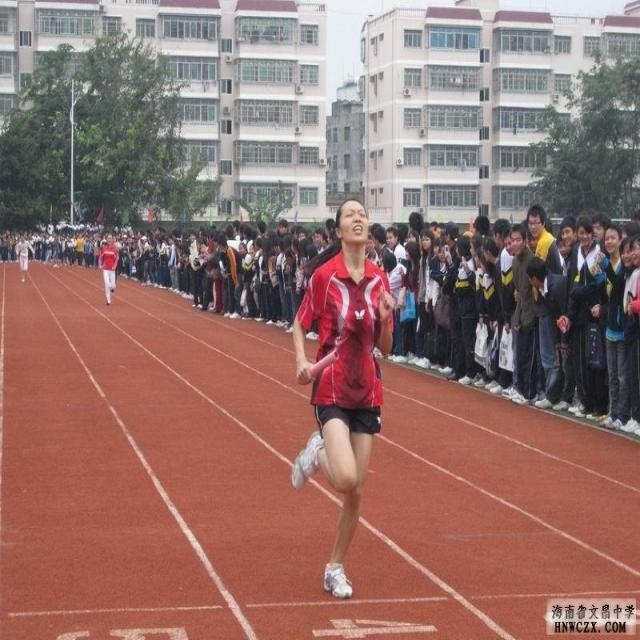

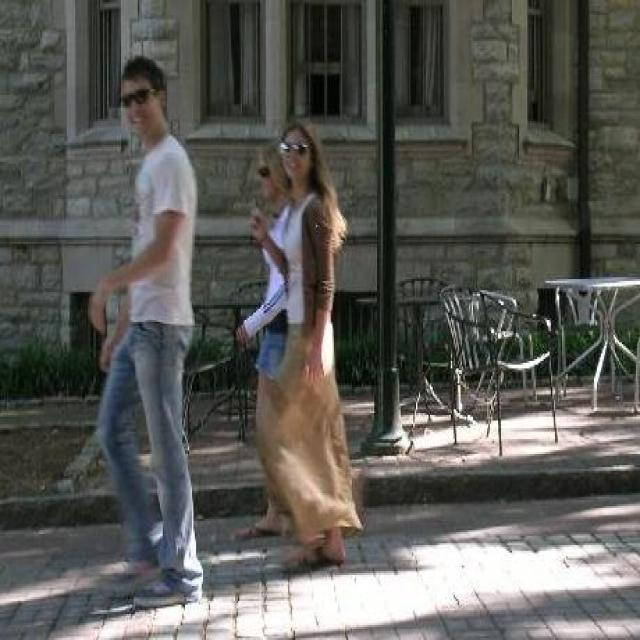

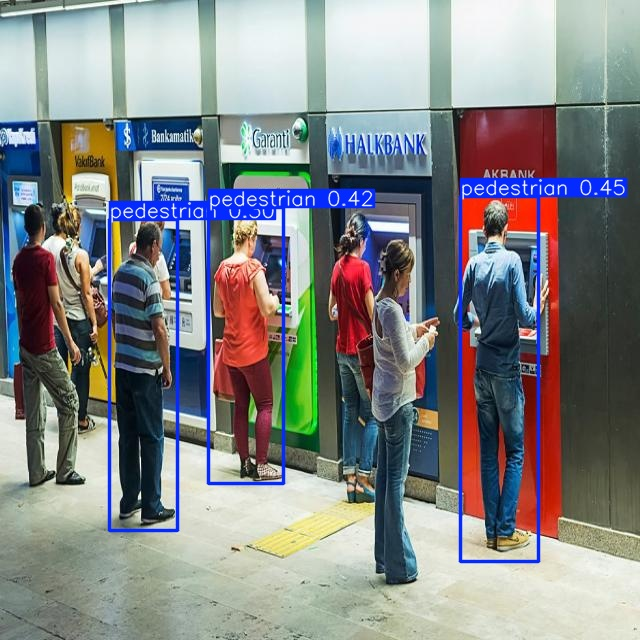

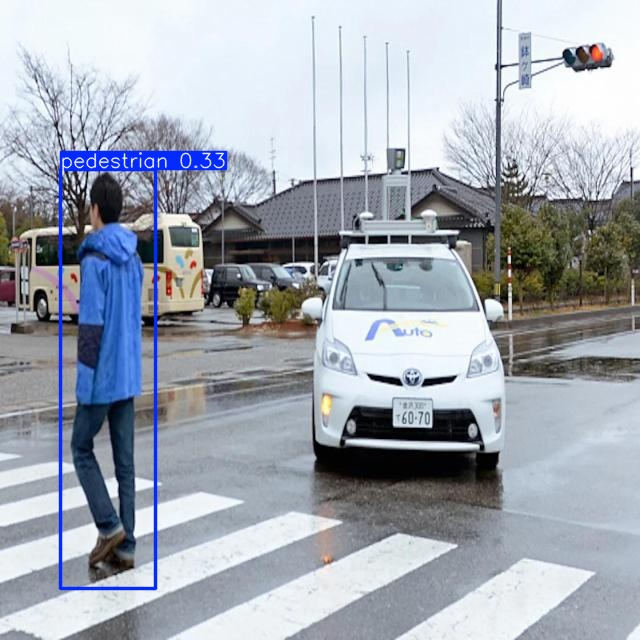

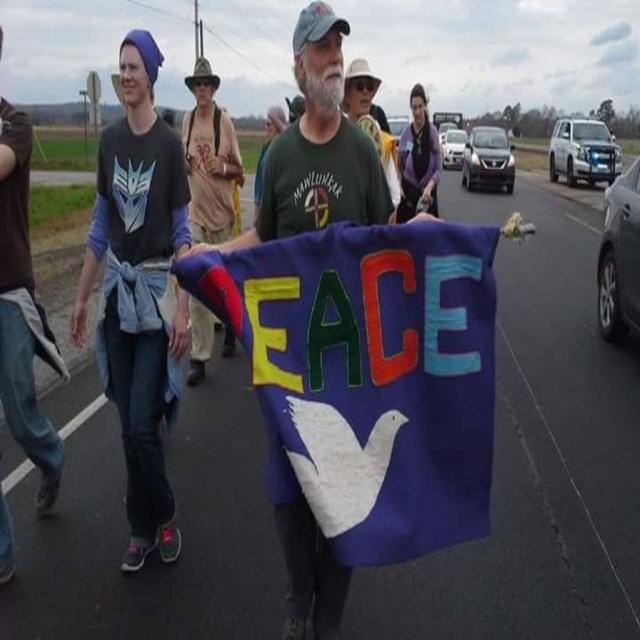

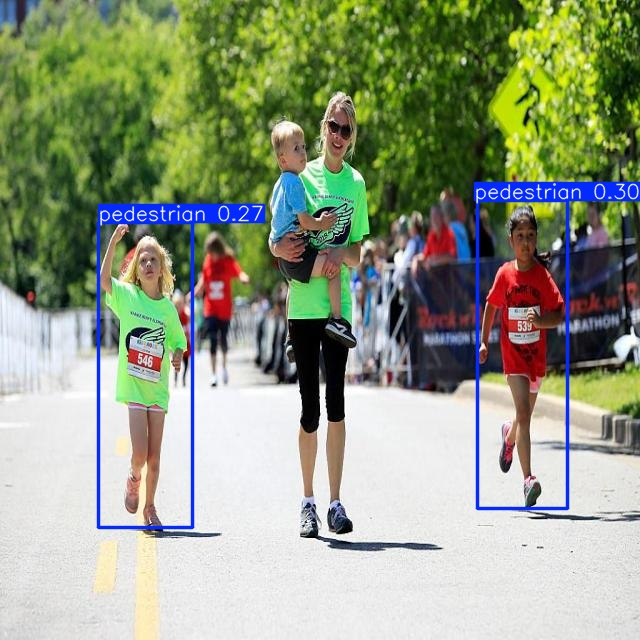

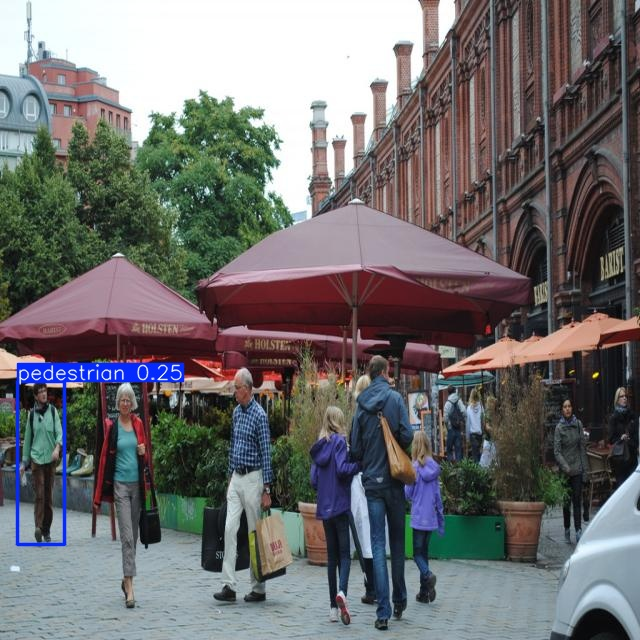

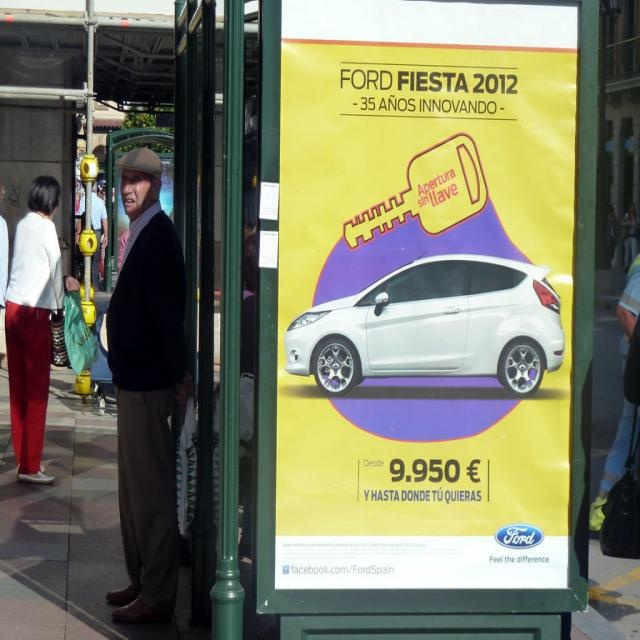

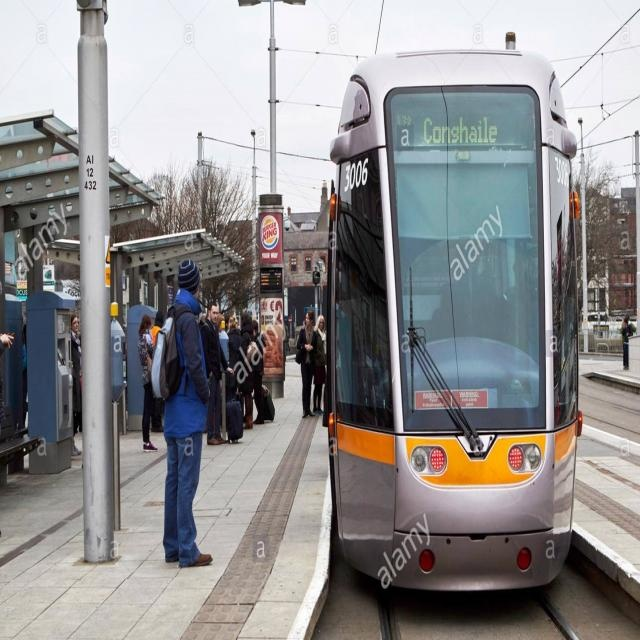

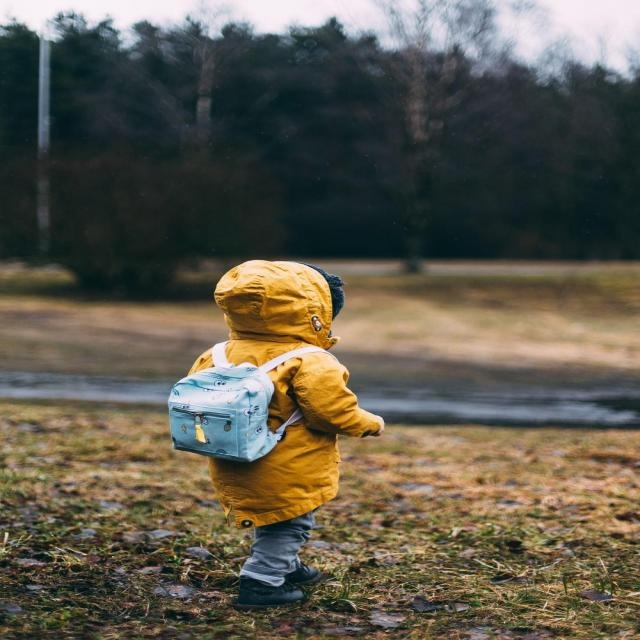

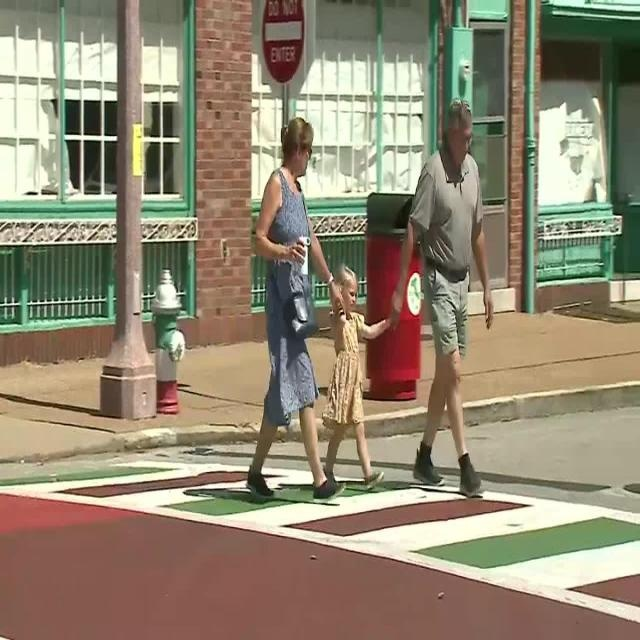

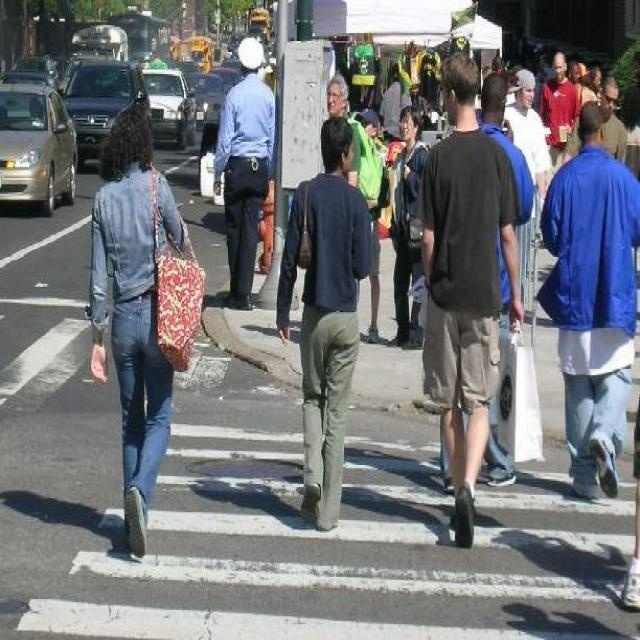

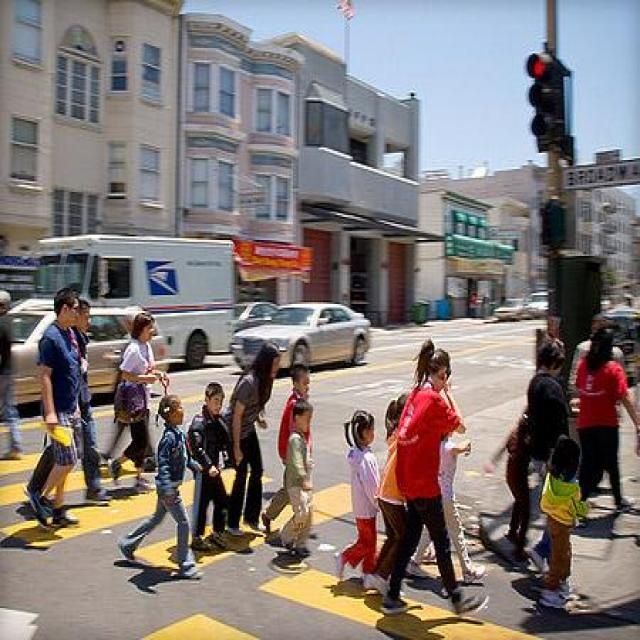

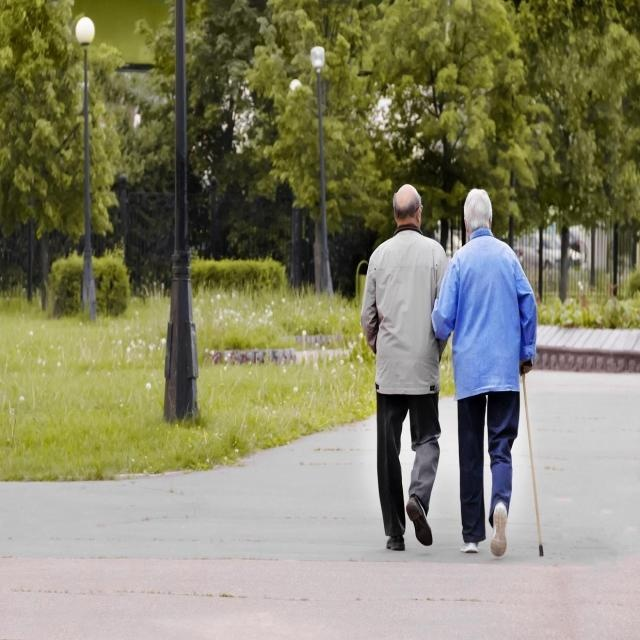

In [ ]:
import glob
from IPython.display import display, Image

for images_path in glob.glob(f'/content/runs/detect/predict/*.jpg'):
  display(Image(filename=images_path, height=600))
  print("\n")

In [28]:
import cv2
from ultralytics import YOLO

# Load the trained YOLOv8 model
model = YOLO('/content/runs/detect/train2/weights/best.pt')

# Open the video file
video_path = '/content/Test_video.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video frame width and height for saving the output
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the codec and create a VideoWriter object to save the output video
output_path = '/content/output_video.mp4'
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

while True:
    ret, frame = cap.read()

    if not ret:
        print("Finished processing the video.")
        break

    # Perform detection on the current frame
    results = model(frame)

    # Draw bounding boxes and labels on the frame
    annotated_frame = results[0].plot()  # Use YOLO's built-in function to annotate the frame

    # Write the frame to the output video
    out.write(annotated_frame)

# Release video file objects
cap.release()
out.release()

print("Output video saved at:", output_path)


0: 352x640 (no detections), 35.5ms
Speed: 2.1ms preprocess, 35.5ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 32.6ms
Speed: 1.9ms preprocess, 32.6ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 32.4ms
Speed: 1.9ms preprocess, 32.4ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 32.9ms
Speed: 1.8ms preprocess, 32.9ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 36.5ms
Speed: 1.8ms preprocess, 36.5ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 36.3ms
Speed: 1.9ms preprocess, 36.3ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 33.1ms
Speed: 1.9ms preprocess, 33.1ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 33.7ms
Speed: 1.9ms preprocess, 33.7ms i